In [1]:
###############################################
# Section 1: Imports and Device Setup
###############################################
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
###############################################
# Section 2: Data Loading and Preprocessing
###############################################
with open("combined_cleaned.txt", "r", encoding="utf-8") as f:
    data = f.read()

chars = sorted(list(set(data)))
vocab_size = len(chars)
print(f"Vocabulary Size: {vocab_size}")

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

data_encoded = np.array([stoi[ch] for ch in data], dtype=np.int64)


Vocabulary Size: 305


In [3]:
###############################################
# Section 3: Model Definition and Global Functions
###############################################
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, hidden_size)
        # GRU applies dropout between layers if num_layers > 1
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden):
        x = self.embed(x)  # (batch, seq_len, hidden_size)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)  # (batch*seq_len, vocab_size)
        return out, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

def get_batch(data, batch_size, seq_length):
    indices = np.random.randint(0, len(data) - seq_length - 1, batch_size)
    x_batch = np.array([data[i:i+seq_length] for i in indices])
    y_batch = np.array([data[i+1:i+seq_length+1] for i in indices])
    return (torch.tensor(x_batch, dtype=torch.long).to(device),
            torch.tensor(y_batch, dtype=torch.long).to(device))

def generate_text(model, start_text="the ", length=300, temperature=1.0):
    start_text = start_text.lower()
    chars_generated = list(start_text)
    hidden = model.init_hidden(1)
    input_seq = torch.tensor([[stoi[ch] for ch in start_text if ch in stoi]], dtype=torch.long).to(device)
    _, hidden = model(input_seq, hidden)
    last_char = input_seq[0, -1]
    for _ in range(length):
        output, hidden = model(last_char.view(1, 1), hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        char = itos[top_i.item()]
        chars_generated.append(char)
        last_char = torch.tensor([stoi[char]], dtype=torch.long).to(device)
    return "".join(chars_generated)

def log_experiment(trial, config, train_loss, val_loss, csv_path='lvl3_log.csv'):
    data_log = {
        'experiment_number': trial,
        'learning_rate': config['lr'],
        'batch_size': config['batch_size'],
        'seq_length': config['seq_length'],
        'hidden_size': config['hidden_size'],
        'num_layers': config['num_layers'],
        'dropout': config['dropout'],
        'num_epochs': config['num_epochs'],
        'training_loss': train_loss,
        'validation_loss': val_loss,
        'training_perplexity': np.exp(train_loss),
        'validation_perplexity': np.exp(val_loss)
    }
    df_new = pd.DataFrame([data_log])
    try:
        df_existing = pd.read_csv(csv_path)
        df = pd.concat([df_existing, df_new], ignore_index=True)
    except (FileNotFoundError, pd.errors.EmptyDataError):
        df = df_new
    df.to_csv(csv_path, index=False)
    return df


Total trials to run: 8

=== Starting Trial 1 with config: {'lr': 0.001, 'batch_size': 128, 'seq_length': 150, 'hidden_size': 512, 'num_epochs': 10, 'num_layers': 2, 'dropout': 0} ===
Trial 1, Epoch [1/10], Batch [100/231], Loss: 1.9061
Trial 1, Epoch [1/10], Batch [200/231], Loss: 1.5810
Trial 1, Epoch [1/10] Average Training Loss: 1.9940
Trial 1, Epoch [1/10] Average Validation Loss: 1.5073
Trial 1, Epoch [2/10], Batch [100/231], Loss: 1.4686
Trial 1, Epoch [2/10], Batch [200/231], Loss: 1.4035
Trial 1, Epoch [2/10] Average Training Loss: 1.4542
Trial 1, Epoch [2/10] Average Validation Loss: 1.3654
Trial 1, Epoch [3/10], Batch [100/231], Loss: 1.3215
Trial 1, Epoch [3/10], Batch [200/231], Loss: 1.3319
Trial 1, Epoch [3/10] Average Training Loss: 1.3537
Trial 1, Epoch [3/10] Average Validation Loss: 1.3143
Trial 1, Epoch [4/10], Batch [100/231], Loss: 1.3196
Trial 1, Epoch [4/10], Batch [200/231], Loss: 1.2775
Trial 1, Epoch [4/10] Average Training Loss: 1.3058
Trial 1, Epoch [4/10] A

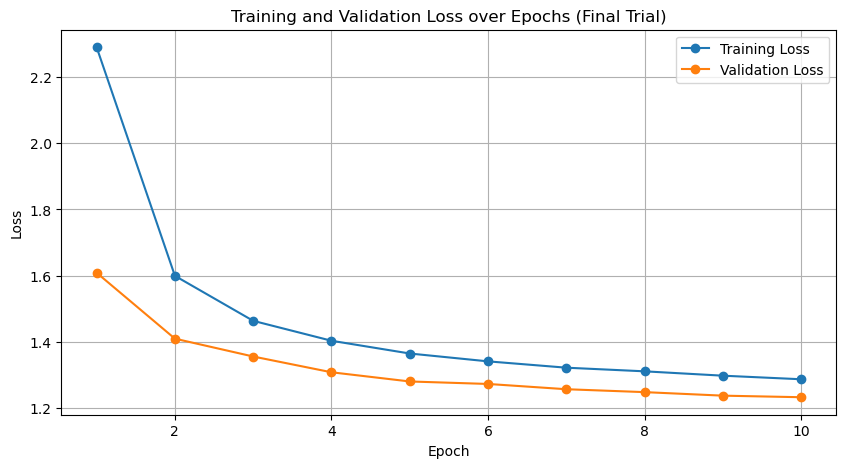

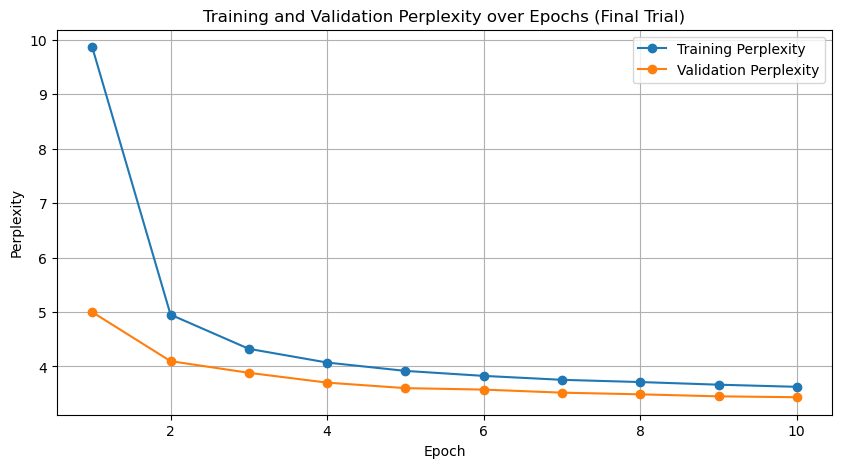

In [4]:
###############################################
# Section 4: Automated Grid Search over Hyperparameters (Level 3)
###############################################
fixed_config = {
    'lr': 0.001,
    'batch_size': 128,
    'seq_length': 150,
    'hidden_size': 512,
    'num_epochs': 10
}

grid_params = {
    'num_layers': [2, 3],
    'dropout': [0, 0.1, 0.3, 0.5]
}

grid_combinations = list(itertools.product(grid_params['num_layers'], grid_params['dropout']))
total_trials = len(grid_combinations)
print(f"Total trials to run: {total_trials}")

split_idx = int(0.9 * len(data_encoded))
train_data = data_encoded[:split_idx]
val_data = data_encoded[split_idx:]

log_csv_path = 'lvl3_log.csv'
log_txt_path = 'lvl3_outputs.txt'
trial_counter = 1

for params in grid_combinations:
    # Build trial configuration
    trial_config = {
        'lr': fixed_config['lr'],
        'batch_size': fixed_config['batch_size'],
        'seq_length': fixed_config['seq_length'],
        'hidden_size': fixed_config['hidden_size'],
        'num_epochs': fixed_config['num_epochs'],
        'num_layers': params[0],
        'dropout': params[1]
    }
    print(f"\n=== Starting Trial {trial_counter} with config: {trial_config} ===")
    
    model = CharRNN(vocab_size, trial_config['hidden_size'], 
                    num_layers=trial_config['num_layers'], dropout=trial_config['dropout']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=trial_config['lr'])
    
    trial_train_losses = []
    trial_val_losses = []
    
    num_train_batches = len(train_data) // (trial_config['batch_size'] * trial_config['seq_length'])
    num_val_batches = len(val_data) // (trial_config['batch_size'] * trial_config['seq_length'])
    
    for epoch in range(trial_config['num_epochs']):
        model.train()
        hidden = model.init_hidden(trial_config['batch_size'])
        total_train_loss = 0
        for i in range(num_train_batches):
            inputs, targets = get_batch(train_data, trial_config['batch_size'], trial_config['seq_length'])
            hidden = hidden.detach()
            optimizer.zero_grad()
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs, targets.view(-1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(f"Trial {trial_counter}, Epoch [{epoch+1}/{trial_config['num_epochs']}], "
                      f"Batch [{i+1}/{num_train_batches}], Loss: {loss.item():.4f}")
        avg_train_loss = total_train_loss / num_train_batches
        trial_train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        val_hidden = model.init_hidden(trial_config['batch_size'])
        with torch.no_grad():
            for i in range(num_val_batches):
                inputs, targets = get_batch(val_data, trial_config['batch_size'], trial_config['seq_length'])
                val_hidden = val_hidden.detach()
                outputs, val_hidden = model(inputs, val_hidden)
                loss = criterion(outputs, targets.view(-1))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / num_val_batches
        trial_val_losses.append(avg_val_loss)
        
        print(f"Trial {trial_counter}, Epoch [{epoch+1}/{trial_config['num_epochs']}] Average Training Loss: {avg_train_loss:.4f}")
        print(f"Trial {trial_counter}, Epoch [{epoch+1}/{trial_config['num_epochs']}] Average Validation Loss: {avg_val_loss:.4f}")
    
    final_train_loss = trial_train_losses[-1]
    final_val_loss = trial_val_losses[-1]
    
    sample_text = generate_text(model, start_text="The ", length=500)
    print(f"\nTrial {trial_counter} Sample Text:")
    print(sample_text)
    
    with open(log_txt_path, "a", encoding="utf-8") as f:
        f.write(f"\nTrial {trial_counter} Sample Text (Config: {trial_config}):\n")
        f.write(sample_text)
        f.write("\n" + "="*50 + "\n")
    
    log_experiment(trial_counter, trial_config, final_train_loss, final_val_loss, csv_path=log_csv_path)
    
    trial_counter += 1

print("\nGrid search complete. Experiment logs saved to 'lvl3_log.csv' and sample outputs appended to 'lvl3_outputs.txt'.")

epochs = np.arange(1, fixed_config['num_epochs'] + 1)
train_perplexities = [np.exp(loss) for loss in trial_train_losses]
val_perplexities = [np.exp(loss) for loss in trial_val_losses]

plt.figure(figsize=(10, 5))
plt.plot(epochs, trial_train_losses, marker='o', label='Training Loss')
plt.plot(epochs, trial_val_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs (Final Trial)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("lvl3_loss_over_epochs.png")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_perplexities, marker='o', label='Training Perplexity')
plt.plot(epochs, val_perplexities, marker='o', label='Validation Perplexity')
plt.title('Training and Validation Perplexity over Epochs (Final Trial)')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)
plt.savefig("lvl3_perplexity_over_epochs.png")
plt.show()